In [13]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import astropy.constants as c
import pandas as pd

In [14]:
# File from https://tasoc.dk/docs/release_notes/tess_sector_04_drn05_v03.pdf Fig. 6.
df = pd.read_csv("tess_cdpp.csv", header=None, sep=";")

In [15]:
cdpp = df[1]*1e-6 # conversion from ppm
cdpp_Tmag = df[0]

# This give the rms on 2 min bins
def CDPP_2min(tmag):
    return cdpp[np.argmin(np.abs(tmag-cdpp_Tmag.values))] * np.sqrt(30)

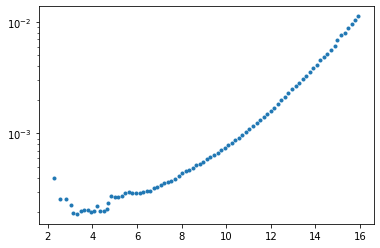

In [16]:
# Here is the same as 10-th percentile CDPP on the S4 report fig 6
plt.plot(cdpp_Tmag, cdpp, ".")
plt.yscale('log')

In [17]:
#I load some necessary lists

TESS_list = pd.read_csv("wg4_target_list.csv", skiprows=[1])
SP_list = pd.read_csv("last_from_daniel.csv")
Tmag = TESS_list["Tmag"].values

This is what I use:

If we assume that the star behave as a black body. we have the planet iradiation:

\begin{equation}
E_{p} = \frac{R_{\star}^2}{a_{\star}^2}\sigma T_{\star}^4
\end{equation}

with $a$ the orbit semi-major axis. $a$ can then be expressed for a planet of $i\times E_{\otimes}$:

\begin{equation}
    E_{p} = iE_{\otimes} \Rightarrow a = \frac{1}{\sqrt{i}}\frac{R_{\star}}{R_{\odot}}\left( \frac{T_{\star}}{T_{\odot}} \right)^2 au
\end{equation}


We can then compute the period $P$ using Kepler's third law:

\begin{equation}
    \frac{a^3}{P^2} = \frac{GM}{4 \pi ^2} \Rightarrow P = \left( \frac{4\pi ^2a^3}{GM} \right)^{1/2}
\end{equation}
    

and the transit duration $D$ as (Exoplanet handbook):

\begin{equation}
D = 13 \left(\frac{M_{\odot}}{M_{\star}}\right)^{1/2}\left(\frac{a}{au}\right)^{1/2}\left(\frac{R_{\star}}{R_{\odot}}\right)^{1/2} hours
\end{equation}

If $N$ is the total number of points of the light-curve sampled at $\delta t$, we simply have:

\begin{equation}
    d = r^2/R_{\star}^2 \quad\quad n = ND/P
\end{equation}

And finally I use


 \begin{equation}
    SNR = \frac{d}{\sigma_{2min}}\sqrt{n}
\end{equation}

with 

\begin{equation}
    \sigma_{2min} = \sqrt{30}\times CDPP_{1hour}
\end{equation}


In [ ]:
# Here is the SNR computed from stellar params, 
def SNR(R, M, Teff, r=1*u.R_earth, Irr=4, sw=None):
    
    depth = (r.to(u.R_sun)/R)**2
    # Period from black-body approximation
    a = (1/np.sqrt(Irr))*(R/u.R_sun)*((Teff/(5772*u.K))**2) * u.au
    P = np.sqrt((a.to(u.m)**3 * 4 * (np.pi**2)) / (c.G * M.to(u.kg))).to(u.day)

    T = 13 * (u.M_sun/M)**(1/2) * (a/u.au)**(1/2) * np.(R/u.R_sun) * u.hour
    
    #signal characteristics
    # 2 x 27 days of observation at 2 min
    dt = (2*u.minute).to(u.hour)
    N = (2*27*u.day).to(u.minute)/(2*u.minute)

    # SNR including red noise from Pont et al, 2006
    n = (N*T.to(u.day))/P
    SNR = (depth/sw) * np.sqrt(n)
    
    return SNR.value

NameError: name 'u' is not defined

In [ ]:
# I compute the SNR for all target in the TESS list and separate program 1 and 2

SNRs_program_1 = []
SNRs_program_2 = []

for sp_id in TESS_list["#Sp_ID"]:
    sp_row = SP_list.loc[SP_list["spc"] == sp_id]
    R = sp_row["radius"].values[0] * u.R_sun
    M = sp_row["mass"].values[0] * u.M_sun
    Teff = sp_row["teff"].values[0] * u.K
    Tmag = TESS_list.loc[TESS_list["#Sp_ID"] == sp_id]["Tmag"].values[0]
    
    sigma_white_2min = CDPP_2min(Tmag)
    snr = SNR(R, M, Teff, sw=sigma_white_2min)
    
    if sp_row["program"].values[0] == 1:
        SNRs_program_1.append(snr)
    elif sp_row["program"].values[0] == 2:
        SNRs_program_2.append(snr)

NameError: name 'TESS_list' is not defined

Text(0, 0.5, 'SNR')

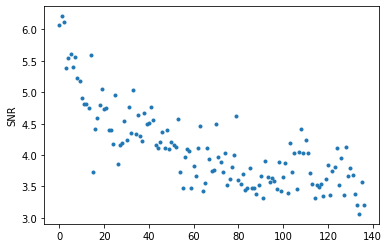

In [32]:
# Here is the SNR of target program 2 based on white noise of S4 report 
plt.plot(SNRs_program_2, ".")
plt.ylabel("SNR")

In [23]:
# As you can see not all of them have SNR > 5 ... I don't see my mistake if any